<a href="https://colab.research.google.com/github/b-fatma/S2I-DM/blob/master/src/6_unsupervised/dbscan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score
import time
from tqdm import tqdm
from collections import deque

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Loading the data

In [32]:
y_train = pd.read_csv('/content/drive/MyDrive/dm_fire_prediction/feature_engineering/v1/y_train.csv')
y_test = pd.read_csv('/content/drive/MyDrive/dm_fire_prediction/feature_engineering/v1/y_test.csv')

X_test = pd.read_csv('/content/drive/MyDrive/dm_fire_prediction/feature_engineering/v1/X_test.csv')
X_train = pd.read_csv('/content/drive/MyDrive/dm_fire_prediction/feature_engineering/v1/X_train.csv')

X_test_scaled = pd.read_csv('/content/drive/MyDrive/dm_fire_prediction/feature_engineering/v1/X_test_scaled.csv')
X_train_scaled = pd.read_csv('/content/drive/MyDrive/dm_fire_prediction/feature_engineering/v1/X_train_scaled.csv')

In [33]:
# since we do not need separate train and test sets in unsupervised learning

X_scaled = pd.concat([X_train_scaled, X_test_scaled], axis=0)
y = pd.concat([y_train, y_test], axis=0)

In [34]:
X_scaled.columns

Index(['GRIDCODE', 'elevation', 'COARSE', 'SAND', 'CLAY', 'BULK', 'ORG_CARBON',
       'PH_WATER', 'TOTAL_N', 'CN_RATIO', 'CEC_SOIL', 'CEC_CLAY', 'CEC_EFF',
       'BSAT', 'ESP', 'TCARBON_EQ', 'GYPSUM', 'ELEC_COND', 'prec_autumn',
       'prec_spring', 'prec_summer', 'prec_winter', 'tmax_warm', 'tmin_warm',
       'tmax_cool', 'tmin_cool'],
      dtype='object')

# DBSCAN

## Tuning eps

- https://stackoverflow.com/questions/15050389/estimating-choosing-optimal-hyperparameters-for-dbscan

- https://medium.com/@mohantysandip/a-step-by-step-approach-to-solve-dbscan-algorithms-by-tuning-its-hyper-parameters-93e693a91289

In [35]:
# X_sample = X_scaled.sample(n=10000, random_state=42)

In [37]:
# from sklearn.model_selection import train_test_split

# X_sample, _, y_sample, _ = train_test_split(
#     X_scaled,
#     y,
#     test_size=0.5,
#     stratify=y,
#     random_state=42
# )

# X_sample.shape, y_sample.shape

((27609, 26), (27609, 1))

In [59]:
import numpy as np
import pandas as pd

# Convert y to 1D array
y1d = y.values.ravel()

# Separate positives and negatives
X_pos = X_scaled[y1d == 1]
y_pos = y1d[y1d == 1]

X_neg = X_scaled[y1d == 0]
y_neg = y1d[y1d == 0]

# Target total sample size
target_n = 30000
n_neg = max(0, target_n - len(X_pos))

if n_neg == 0:
    X_sample = X_pos.copy()
    y_sample = y_pos.copy()
else:
    idx = np.random.choice(len(X_neg), size=n_neg, replace=False)
    X_sample = pd.concat([X_pos, X_neg.iloc[idx]], axis=0)
    y_sample = np.concatenate([y_pos, y_neg[idx]])

# Shuffle
shuff_idx = np.random.default_rng(42).permutation(len(y_sample))
X_sample = X_sample.iloc[shuff_idx].reset_index(drop=True)
y_sample = y_sample[shuff_idx]

X_sample.shape, y_sample.shape


((30000, 26), (30000,))

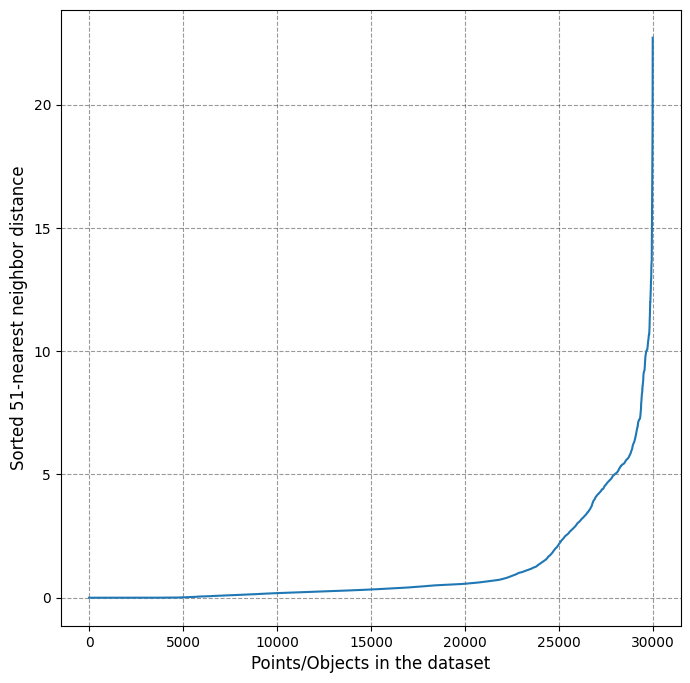

In [60]:
def get_kdist_plot(X=None, k=None, radius_nbrs=1.0):

    nbrs = NearestNeighbors(n_neighbors=k, radius=radius_nbrs).fit(X)

    # For each point, compute distances to its k-nearest neighbors
    distances, indices = nbrs.kneighbors(X)

    distances = np.sort(distances, axis=0)
    distances = distances[:, k-1]

    # Plot the sorted K-nearest neighbor distance for each point in the dataset
    plt.figure(figsize=(8,8))
    plt.plot(distances)
    plt.xlabel('Points/Objects in the dataset', fontsize=12)
    plt.ylabel('Sorted {}-nearest neighbor distance'.format(k), fontsize=12)
    plt.grid(True, linestyle="--", color='black', alpha=0.4)
    plt.show()
    plt.close()


k = 2 * X_scaled.shape[-1] - 1 # k=2*{dim(dataset)} - 1
get_kdist_plot(X=X_sample, k=k)

=> eps ~ between 2.5 and 5.5

eps=2.50: Silhouette=0.3955, Clusters=45, Noise=3665
eps=3.00: Silhouette=0.4354, Clusters=31, Noise=3326
eps=3.50: Silhouette=0.4151, Clusters=25, Noise=2667
eps=4.00: Silhouette=0.5557, Clusters=20, Noise=2264
eps=4.50: Silhouette=0.5318, Clusters=18, Noise=1594
eps=5.00: Silhouette=0.5350, Clusters=13, Noise=1183


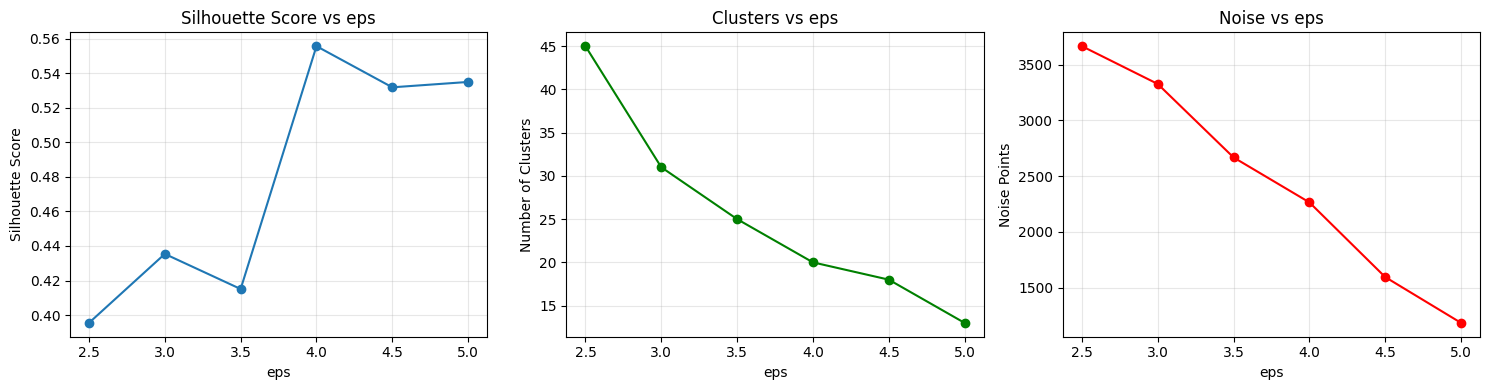


Best eps: 4.00 with score: 0.5557


In [12]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

eps_values = np.arange(2.5, 5.5, 0.5)
silhouette_scores = []
n_clusters_list = []
n_noise_list = []

min_samples = 2 * X_sample.shape[-1]

for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(X_sample)

    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)

    if n_clusters > 1:
        mask = labels != -1
        score = silhouette_score(X_sample[mask], labels[mask]) if sum(mask) > 0 else -1
        silhouette_scores.append(score)
    else:
        silhouette_scores.append(-1)

    n_clusters_list.append(n_clusters)
    n_noise_list.append(n_noise)

    print(f"eps={eps:.2f}: Silhouette={silhouette_scores[-1]:.4f}, Clusters={n_clusters}, Noise={n_noise}")

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(eps_values, silhouette_scores, marker='o')
axes[0].set_xlabel('eps')
axes[0].set_ylabel('Silhouette Score')
axes[0].set_title('Silhouette Score vs eps')
axes[0].grid(True, alpha=0.3)

axes[1].plot(eps_values, n_clusters_list, marker='o', color='green')
axes[1].set_xlabel('eps')
axes[1].set_ylabel('Number of Clusters')
axes[1].set_title('Clusters vs eps')
axes[1].grid(True, alpha=0.3)

axes[2].plot(eps_values, n_noise_list, marker='o', color='red')
axes[2].set_xlabel('eps')
axes[2].set_ylabel('Noise Points')
axes[2].set_title('Noise vs eps')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

best_eps, best_score = max([(eps, score) for eps, score in zip(eps_values, silhouette_scores) if score > -1], key=lambda x: x[1])
print(f"\nBest eps: {best_eps:.2f} with score: {best_score:.4f}")

# From scratch

In [10]:
class DBSCAN_:
    def __init__(self, eps=0.5, min_samples=5):
        """
        Memory-efficient DBSCAN clustering implementation

        Parameters:
        -----------
        eps : float, maximum distance between two samples
        min_samples : int, minimum samples in neighborhood for core point
        """
        self.eps = eps
        self.min_samples = min_samples
        self.labels_ = None
        self.core_sample_indices_ = None
        self.n_clusters_ = 0

    def _get_neighbors(self, X, point_idx):
        """
        Get neighbors for a single point (computed on-the-fly)
        This avoids storing the entire distance matrix
        """
        point = X[point_idx]
        # Compute distances to all points
        distances = np.sqrt(np.sum((X - point) ** 2, axis=1))
        # Return indices of neighbors within eps
        return np.where(distances <= self.eps)[0]

    def _get_neighbors_batch(self, X, point_indices, batch_size=500):
        """
        Get neighbors for multiple points in small batches
        """
        all_neighbors = []

        for i in range(0, len(point_indices), batch_size):
            batch_indices = point_indices[i:i+batch_size]
            batch_points = X[batch_indices]

            # Compute distances for this batch
            # Shape: (batch_size, n_samples)
            distances = np.sqrt(np.sum((batch_points[:, np.newaxis, :] - X[np.newaxis, :, :]) ** 2, axis=2))

            # Find neighbors for each point in batch
            for j, global_idx in enumerate(batch_indices):
                neighbors = np.where(distances[j] <= self.eps)[0]
                all_neighbors.append((global_idx, neighbors))

        return all_neighbors

    def _expand_cluster(self, X, labels, point_idx, cluster_id):
        """
        Expand cluster from a core point
        Computes neighbors on-the-fly to save memory
        """
        queue = deque([point_idx])
        labels[point_idx] = cluster_id

        while queue:
            current_point = queue.popleft()

            # Get neighbors for current point
            neighbors = self._get_neighbors(X, current_point)

            # If current point is a core point
            if len(neighbors) >= self.min_samples:
                for neighbor_idx in neighbors:
                    # If unvisited or noise
                    if labels[neighbor_idx] <= 0:
                        if labels[neighbor_idx] == -1:
                            # Change noise to border point
                            labels[neighbor_idx] = cluster_id
                        else:
                            # Unvisited point - add to cluster and queue
                            labels[neighbor_idx] = cluster_id
                            queue.append(neighbor_idx)

    def fit(self, X):
        """
        Fit DBSCAN to data using memory-efficient approach

        Parameters:
        -----------
        X : array-like, shape (n_samples, n_features)
        """
        n_samples = X.shape[0]

        print(f"Starting Memory-Efficient DBSCAN")
        print(f"eps={self.eps}, min_samples={self.min_samples}")
        print(f"Data shape: {X.shape}")
        print(f"\nThis will compute neighbors on-the-fly to save memory...")

        # Initialize all points as unvisited (0), -1 = noise
        self.labels_ = np.zeros(n_samples, dtype=int)

        # First pass: identify core points in batches
        print("\nPass 1: Identifying core points...")
        core_samples = []
        batch_size = 500

        for i in tqdm(range(0, n_samples, batch_size), desc="Scanning for core points"):
            end_i = min(i + batch_size, n_samples)
            batch_indices = list(range(i, end_i))

            # Get neighbors for this batch
            batch_neighbors = self._get_neighbors_batch(X, batch_indices, batch_size=100)

            for point_idx, neighbors in batch_neighbors:
                if len(neighbors) >= self.min_samples:
                    core_samples.append(point_idx)

        self.core_sample_indices_ = np.array(core_samples)
        print(f"Found {len(core_samples)} core points ({len(core_samples)/n_samples*100:.1f}%)")

        # Second pass: form clusters
        print("\nPass 2: Forming clusters...")
        cluster_id = 0

        for point_idx in tqdm(core_samples, desc="Building clusters"):
            # Skip if already assigned
            if self.labels_[point_idx] != 0:
                continue

            # Start new cluster
            cluster_id += 1
            self._expand_cluster(X, self.labels_, point_idx, cluster_id)

        # Mark remaining unvisited points as noise
        self.labels_[self.labels_ == 0] = -1

        self.n_clusters_ = cluster_id

        return self

    def fit_predict(self, X):
        """Fit and return cluster labels"""
        self.fit(X)
        return self.labels_

In [19]:
# the implmentation expects numpy arrays
X_scaled_np = X_scaled.to_numpy()
y_np = y.to_numpy()

In [20]:
dbscan = DBSCAN_(eps=4.5, min_samples=2 * X_scaled.shape[-1])

s_time = time.time()
y_pred = dbscan.fit_predict(X_scaled_np)
print(f"Training time: {time.time() - s_time:.2f}s")

n_clusters = len(set(y_pred)) - (1 if -1 in y_pred else 0)
n_noise = list(y_pred).count(-1)
print(f"Clusters: {n_clusters}, Noise points: {n_noise}")

Starting Memory-Efficient DBSCAN
eps=4.5, min_samples=52
Data shape: (55219, 26)

This will compute neighbors on-the-fly to save memory...

Pass 1: Identifying core points...


Scanning for core points: 100%|██████████| 111/111 [07:03<00:00,  3.82s/it]


Found 52327 core points (94.8%)

Pass 2: Forming clusters...


Building clusters: 100%|██████████| 52327/52327 [09:10<00:00, 95.04it/s]   

Training time: 974.33s
Clusters: 26, Noise points: 2023


In [11]:
from sklearn.cluster import DBSCAN as DBSCAN_sklearn

dbscan = DBSCAN_sklearn(eps=4, min_samples=2 * X_sample.shape[-1])

s_time = time.time()
y_pred = dbscan.fit_predict(X_sample)
print(f"Training time: {time.time() - s_time:.2f}s")

n_clusters = len(set(y_pred)) - (1 if -1 in y_pred else 0)
n_noise = list(y_pred).count(-1)
print(f"Clusters: {n_clusters}, Noise points: {n_noise}")

Training time: 14.38s
Clusters: 20, Noise points: 2264


In [14]:
import hdbscan

clusterer = hdbscan.HDBSCAN(
    min_cluster_size=2 * X_sample.shape[-1],
    min_samples=None,
    metric='euclidean'
)

s_time = time.time()
y_pred_hdb = clusterer.fit_predict(X_sample)
print(f"Training time: {time.time() - s_time:.2f}s")

n_clusters_hdb = len(set(y_pred_hdb)) - (1 if -1 in y_pred_hdb else 0)
n_noise_hdb = list(y_pred_hdb).count(-1)
print(f"Clusters: {n_clusters_hdb}, Noise points: {n_noise_hdb}")

# Compare
print(f"\nComparison:")
print(f"DBSCAN: {n_clusters} clusters, {n_noise} noise")
print(f"HDBSCAN: {n_clusters_hdb} clusters, {n_noise_hdb} noise")

Training time: 15.29s
Clusters: 96, Noise points: 7068

Comparison:
DBSCAN: 13 clusters, 1183 noise
HDBSCAN: 96 clusters, 7068 noise


In [15]:
# DBSCAN score
mask_db = y_pred != -1
if mask_db.sum() > 0 and n_clusters > 1:DBSCAN
    score_db = silhouette_score(X_sample[mask_db], y_pred[mask_db])
    print(f"DBSCAN Silhouette: {score_db:.4f}")

# HDBSCAN score
mask_hdb = y_pred_hdb != -1
if mask_hdb.sum() > 0 and n_clusters_hdb > 1:
    score_hdb = silhouette_score(X_sample[mask_hdb], y_pred_hdb[mask_hdb])
    print(f"HDBSCAN Silhouette: {score_hdb:.4f}")

DBSCAN Silhouette: 0.5557
HDBSCAN Silhouette: 0.5618


In [16]:
print("\nCluster Distribution:")
unique, counts = np.unique(y_pred, return_counts=True)
for cluster, count in zip(unique, counts):
    print(f"  Cluster {cluster}: {count} samples ({count/len(y_pred)*100:.2f}%)")


Cluster Distribution:
  Cluster -1: 2264 samples (8.20%)
  Cluster 0: 20809 samples (75.37%)
  Cluster 1: 364 samples (1.32%)
  Cluster 2: 138 samples (0.50%)
  Cluster 3: 59 samples (0.21%)
  Cluster 4: 128 samples (0.46%)
  Cluster 5: 305 samples (1.10%)
  Cluster 6: 1280 samples (4.64%)
  Cluster 7: 59 samples (0.21%)
  Cluster 8: 392 samples (1.42%)
  Cluster 9: 150 samples (0.54%)
  Cluster 10: 492 samples (1.78%)
  Cluster 11: 53 samples (0.19%)
  Cluster 12: 60 samples (0.22%)
  Cluster 13: 317 samples (1.15%)
  Cluster 14: 184 samples (0.67%)
  Cluster 15: 230 samples (0.83%)
  Cluster 16: 65 samples (0.24%)
  Cluster 17: 52 samples (0.19%)
  Cluster 18: 53 samples (0.19%)
  Cluster 19: 155 samples (0.56%)


In [40]:
print("\nFire Instances per Cluster:")
fire_pct = []
for cluster in unique:
    mask = y_pred == cluster
    n_fires = y_sample.squeeze()[mask].sum()
    n_total = mask.sum()
    pct = (n_fires / n_total * 100) if n_total > 0 else 0
    fire_pct.append(pct)
    print(f"  Cluster {cluster}: {n_fires}/{n_total} fires ({pct}%)")


Fire Instances per Cluster:
  Cluster -1: 679/2264 fires (29.99116607773852%)
  Cluster 0: 4997/20809 fires (24.01364794079485%)
  Cluster 1: 51/364 fires (14.010989010989011%)
  Cluster 2: 9/138 fires (6.521739130434782%)
  Cluster 3: 2/59 fires (3.389830508474576%)
  Cluster 4: 10/128 fires (7.8125%)
  Cluster 5: 0/305 fires (0.0%)
  Cluster 6: 105/1280 fires (8.203125%)
  Cluster 7: 0/59 fires (0.0%)
  Cluster 8: 98/392 fires (25.0%)
  Cluster 9: 32/150 fires (21.333333333333336%)
  Cluster 10: 141/492 fires (28.65853658536585%)
  Cluster 11: 0/53 fires (0.0%)
  Cluster 12: 11/60 fires (18.333333333333332%)
  Cluster 13: 7/317 fires (2.2082018927444795%)
  Cluster 14: 73/184 fires (39.67391304347826%)
  Cluster 15: 91/230 fires (39.565217391304344%)
  Cluster 16: 30/65 fires (46.15384615384615%)
  Cluster 17: 4/52 fires (7.6923076923076925%)
  Cluster 18: 8/53 fires (15.09433962264151%)
  Cluster 19: 23/155 fires (14.838709677419354%)


# PCA -> DBSCAN

In [61]:
import time
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN as DBSCAN_sklearn
from sklearn.metrics import silhouette_score

# ----------------------------
# Step 1: PCA for dimensionality reduction
# Intuition: DBSCAN memory and distance computations scale badly with high dims.
# Reducing dimensions keeps main variance while making clustering feasible.
# ----------------------------
n_components = 5
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_sample)

print(f"PCA reduced shape: {X_pca.shape}")
explained = np.sum(pca.explained_variance_ratio_)
print(f"Variance explained by {n_components} components: {explained:.2%}")

# ----------------------------
# Step 2: DBSCAN clustering
# eps: neighborhood radius
# min_samples: suggested 2 × number of PCA features
# ----------------------------
dbscan = DBSCAN_sklearn(eps=4, min_samples=2 * X_pca.shape[-1])

s_time = time.time()
y_pred = dbscan.fit_predict(X_pca)
print(f"Training time: {time.time() - s_time:.2f}s")

# ----------------------------
# Step 3: Metrics & summary
# ----------------------------
n_clusters = len(set(y_pred)) - (1 if -1 in y_pred else 0)
n_noise = list(y_pred).count(-1)
print(f"Clusters: {n_clusters}, Noise points: {n_noise}")

# Silhouette score
if n_clusters > 1:
    mask = y_pred != -1
    sil = silhouette_score(X_pca[mask], y_pred[mask])
    print(f"Silhouette score (noise excluded): {sil:.4f}")
else:
    print("Silhouette score not defined (only 1 cluster)")


PCA reduced shape: (30000, 5)
Variance explained by 5 components: 99.29%
Training time: 33.80s
Clusters: 34, Noise points: 233
Silhouette score (noise excluded): 0.5819
Cluster sizes (including -1 for noise): {np.int64(-1): np.int64(233), np.int64(0): np.int64(23161), np.int64(1): np.int64(1417), np.int64(2): np.int64(106), np.int64(3): np.int64(74), np.int64(4): np.int64(1740), np.int64(5): np.int64(1515), np.int64(6): np.int64(61), np.int64(7): np.int64(129), np.int64(8): np.int64(244), np.int64(9): np.int64(46), np.int64(10): np.int64(23), np.int64(11): np.int64(248), np.int64(12): np.int64(245), np.int64(13): np.int64(19), np.int64(14): np.int64(188), np.int64(15): np.int64(28), np.int64(16): np.int64(36), np.int64(17): np.int64(192), np.int64(18): np.int64(45), np.int64(19): np.int64(37), np.int64(20): np.int64(21), np.int64(21): np.int64(12), np.int64(22): np.int64(24), np.int64(23): np.int64(16), np.int64(24): np.int64(10), np.int64(25): np.int64(10), np.int64(26): np.int64(10),

In [62]:
print("\nFire Instances per Cluster:")
fire_pct = []
for cluster in unique:
    mask = y_pred == cluster
    n_fires = y_sample.squeeze()[mask].sum()
    n_total = mask.sum()
    pct = (n_fires / n_total * 100) if n_total > 0 else 0
    fire_pct.append(pct)
    print(f"  Cluster {cluster}: {n_fires}/{n_total} fires ({pct}%)")


Fire Instances per Cluster:
  Cluster -1: 97/233 fires (41.63090128755365%)
  Cluster 0: 10135/23161 fires (43.758905055912955%)
  Cluster 1: 671/1417 fires (47.353563867325335%)
  Cluster 2: 73/106 fires (68.86792452830188%)
  Cluster 3: 53/74 fires (71.62162162162163%)
  Cluster 4: 308/1740 fires (17.70114942528736%)
  Cluster 5: 685/1515 fires (45.21452145214521%)
  Cluster 6: 54/61 fires (88.52459016393442%)
  Cluster 7: 88/129 fires (68.21705426356588%)
  Cluster 8: 210/244 fires (86.0655737704918%)
  Cluster 9: 28/46 fires (60.86956521739131%)
  Cluster 10: 16/23 fires (69.56521739130434%)
  Cluster 11: 13/248 fires (5.241935483870968%)
  Cluster 12: 0/245 fires (0.0%)
  Cluster 13: 4/19 fires (21.052631578947366%)
  Cluster 14: 103/188 fires (54.78723404255319%)
  Cluster 15: 19/28 fires (67.85714285714286%)
  Cluster 16: 17/36 fires (47.22222222222222%)
  Cluster 17: 45/192 fires (23.4375%)
  Cluster 18: 3/45 fires (6.666666666666667%)
  Cluster 19: 15/37 fires (40.54054054054